# **XPM 1D Solver**

The coupled NLS Equations of two co-propagating pulses are given by:
$$
\frac{\partial A_1}{\partial z} + \frac{1}{v_{g1}} \frac{\partial A_1}{\partial t} + \frac{i\beta_{21}}{2} \frac{\partial^2 A_1}{\partial t^2} + \frac{\alpha_1}{2} A_1 = i\gamma_1 (|A_1|^2 + 2 f_{12}|A_2|^2) A_1,
\\
\frac{\partial A_2}{\partial z} + \frac{1}{v_{g2}} \frac{\partial A_2}{\partial t} + \frac{i\beta_{22}}{2} \frac{\partial^2 A_2}{\partial t^2} + \frac{\alpha_2}{2} A_2 = i\gamma_2 (|A_2|^2 + 2 f_{21}|A_1|^2) A_2,
$$
where $\beta_{21}$ and $\beta_{22}$, as well as $\gamma_1$ and $\gamma_2$ are different for different media and depend on the mode (frequency) of light and where $f_{jk}$ is the overlap integral (a scalar value dependent on the mode and nature of the two propagating waves). Neglecting loss terms $\alpha = 0$ and assuming overlap $f_{jk} = 1$:
$$
\frac{\partial A_1}{\partial z} 
= - i\frac{\beta_{21}}{2} \frac{\partial^2 A_1}{\partial T^2} + i\gamma_1|A_1|^2A_1 + 2i\gamma_1|A_2|^2A_1, \\[6pt] = \bigl[ \mathscr{L} + \mathscr{N}_1 + \mathscr{N}_2 \bigr] A_1
$$
$$
\frac{\partial A_2}{\partial z}  
= - d \frac{\partial A_2}{\partial T} -
i\frac{\beta_{22}}{2} \frac{\partial^2 A_2}{\partial T^2} + i\gamma_2|A_2|^2A_2 + 2i\gamma_2  |A_1|^2 A_2 = \bigl[ \mathscr{L}_1 + \mathscr{L}_2 + \mathscr{N}_2 + \mathscr{N}_1 \bigr] A_2
$$

where $T = t - \frac{z}{v_{g1}}$ and $d = \frac{v_{g1} - v_{g2}}{v_{g1} v_{g2}}$. However, we can further simplify by assuming $\beta_{11} = \beta_{12}$ giving:
$$
\frac{\partial A_1}{\partial z} 
= - i\frac{\beta_{21}}{2} \frac{\partial^2 A_1}{\partial T^2} + i\gamma_1 \bigl[ |A_1|^2 + 2|A_2|^2 \bigr]A_1, \\[6pt] = \bigl[ \mathscr{L_1} + \mathscr{N}_1  \bigr] A_1
$$
$$
\frac{\partial A_2}{\partial z}  
= -
i\frac{\beta_{22}}{2} \frac{\partial^2 A_2}{\partial T^2} + i\gamma_2 \bigl[ |A_2|^2 + 2|A_1|^2 \bigr]A_2, \\[6pt] = \bigl[ \mathscr{L_2} + \mathscr{N}_2  \bigr] A_2
$$


compare this with the 1D NLSE for a single propagating wave:

$$    
\frac{\partial A}{\partial z} = -i\frac{\beta_2}{2} \frac{\partial^2 A}{\partial t^2} + i\gamma |A|^2 A.
$$

The first term of RHS corresponds to the GVD dispersion (parametrized by $\beta_2$) and the second term is Kerr nonlinearity. 

This can be solved numerically using split-step Fourier method:
$$
    A(z + \Delta z, T) = \mathcal{F}^{-1}\left\{ e^{i\frac{\beta_2}{2} (\omega)^2 \Delta z}  \cdot   \mathcal{F} \left\{   e^{i \gamma |A(z, T)|^2 \Delta z}   A(z, T) \right\}  \right\} 
$$

Thus **the numerical solution to the XPM wave-propagation** for the wave $j$ interacting with wave $k$ is
$$
    A(z + \Delta z, T) = \mathcal{F}^{-1}\left\{ e^{i\frac{\beta_2j}{2} \omega^2 \Delta z}  \cdot   \mathcal{F} \left\{   e^{i \gamma (|A_j(z, T)|^2 + 2|A_k(z,T)|^2) \Delta z} A_j(z, T) \right\}  \right\} 
$$
or, using Strang splitting:
$$
A_j(z + \Delta z, T) 
= 
e^{\,i \gamma \bigl(|A_j(z, T)|^2 + 2|A_k(z, T)|^2\bigr) \frac{\Delta z}{2}}
\,\mathcal{F}^{-1}
\!\left\{
   e^{\,i\frac{\beta_{2j}}{2} \omega^2 \Delta z}
   \,\mathcal{F}\!\left[
      e^{\,i \gamma \bigl(|A_j(z, T)|^2 + 2|A_k(z, T)|^2\bigr) \frac{\Delta z}{2}}
      A_j(z, T)
   \right]
\right\}.
$$

Questions:
- Do we use the same "temporal window size" $L_t$ for both of the waves?

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import os

# ml imports
import torch

# import module
from nlse import *

## **Test Simulation**

### Parameters

In [2]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points

# define medium parameters
beta2_j = -20           # Dispersion coefficient in ps^2/km
beta2_k = -20           # Dispersion coefficient in ps^2/km
gamma_j = 20
gamma_k = 20

### Simulation

In [3]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center_j = Lt / 2         # Center of the Gaussian pulse
T0_j = 10.0             # Width of the Gaussian pulse on ps
P0_j = 0.007                # sqrt of the peak power of the Gaussian pulse

center_k = Lt / 2         # Center of the Gaussian pulse
T0_k = 10.0             # Width of the Gaussian pulse on ps
P0_k = 0.007                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain_j = torch.nn.Parameter(gaussian_pulse(t, center_j, T0_j, P0_j).clone().detach().requires_grad_(True))
Ain_k = torch.nn.Parameter(gaussian_pulse(t, center_k, T0_k, P0_k).clone().detach().requires_grad_(True))

# Perform the split-step Fourier method
A_j_evolution, A_k_evolution  = split_step_fourier_xpm(Ain_j, Ain_k, dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)


### Plotting

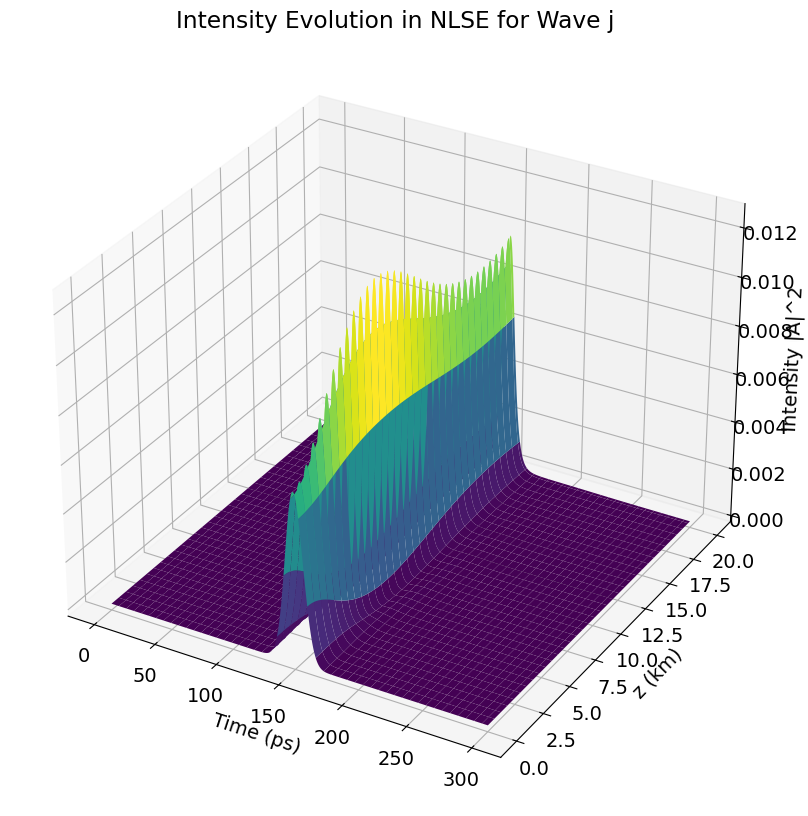

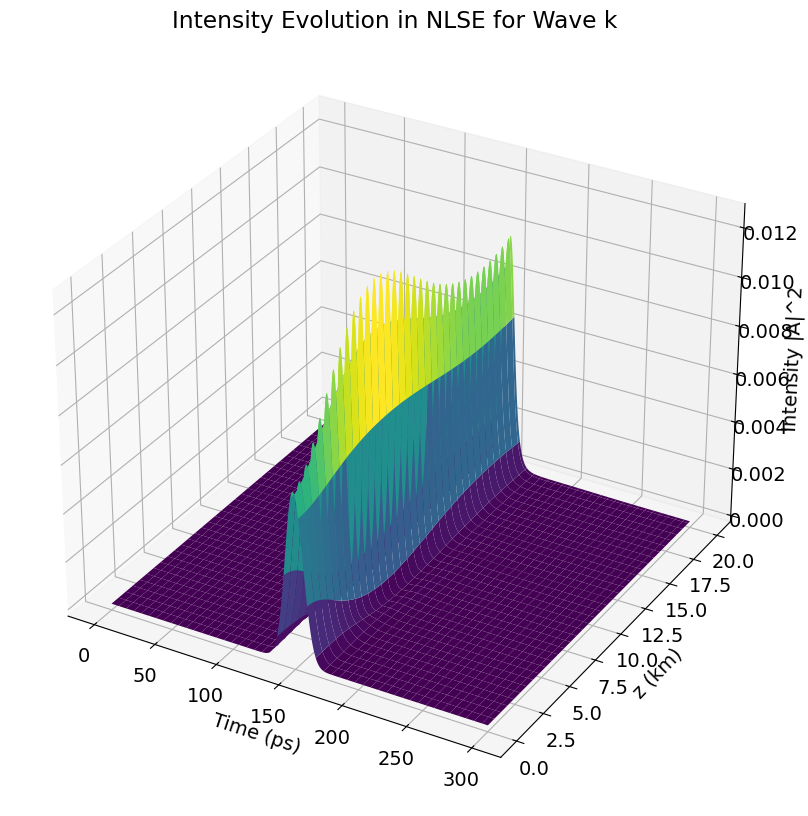

In [4]:
plot_intensity_evolution(A_j_evolution, t, Lz, Nz, wave_name='Wave j')
plot_intensity_evolution(A_k_evolution, t, Lz, Nz, wave_name='Wave k')

## **Sanity Check Soliton Solutions**
Fundamental soliton pulse for "single-wave" propagation has the sech shape
\begin{equation}
    A_s(z,t) = A_0 sech( \frac{t}{T_0} ) e^{-i\frac{\beta_2}{2T_0^2} z}.
\end{equation}

This is the "optimal" pulse for the given medium which we will try to find using PyTorch.


### Parameters

In [5]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points

# define medium parameters
beta2_j = -20           # anomalous GVD region
beta2_k = -20           # normal GVD region
gamma_j = 20
gamma_k = 20

# define soliton parameters
T0 = 10.0 # optimal val
A0 = 0.1 # optimal val
center = Lt / 2

### Simulation

In [6]:
# define function for getting soltion pulse
def sech_pulse(t, center, T0, A0):
    """Generate a Gaussian pulse."""
    return A0* 1/torch.cosh( (t-center)/ T0 + 1e-16) + 1e-16

t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)
Ain_j1 = sech_pulse(t, center, T0, A0)
Ain_k1 = torch.zeros_like(Ain_j)

Ain_k2 = sech_pulse(t, center, T0, A0)
Ain_j2 = torch.zeros_like(Ain_k2)

# Perform the split-step Fourier method
A_j_evolution1, A_k_evolution1  = split_step_fourier_xpm(Ain_j1, Ain_k1, dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)
A_j_evolution2, A_k_evolution2  = split_step_fourier_xpm(Ain_j2, Ain_k2, dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)

### Plotting

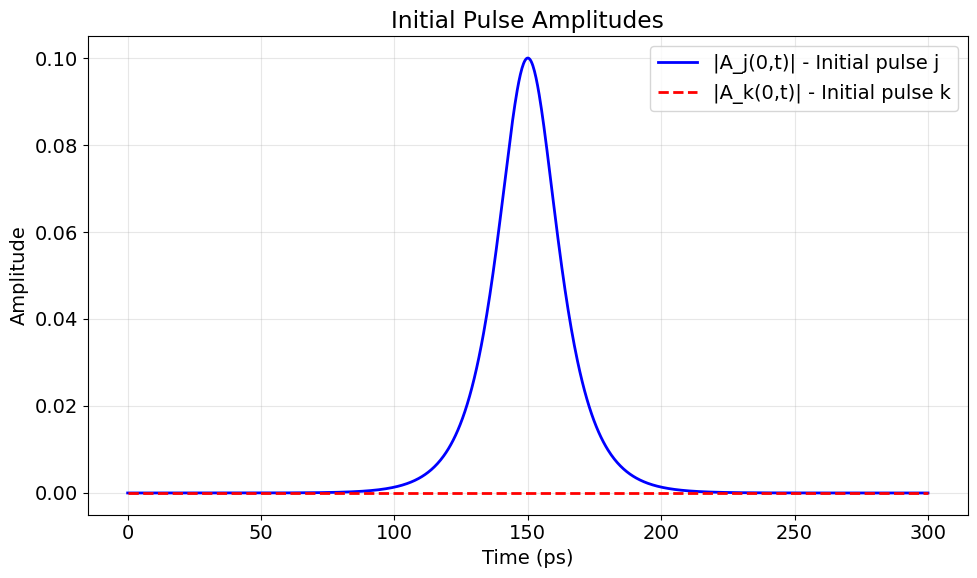

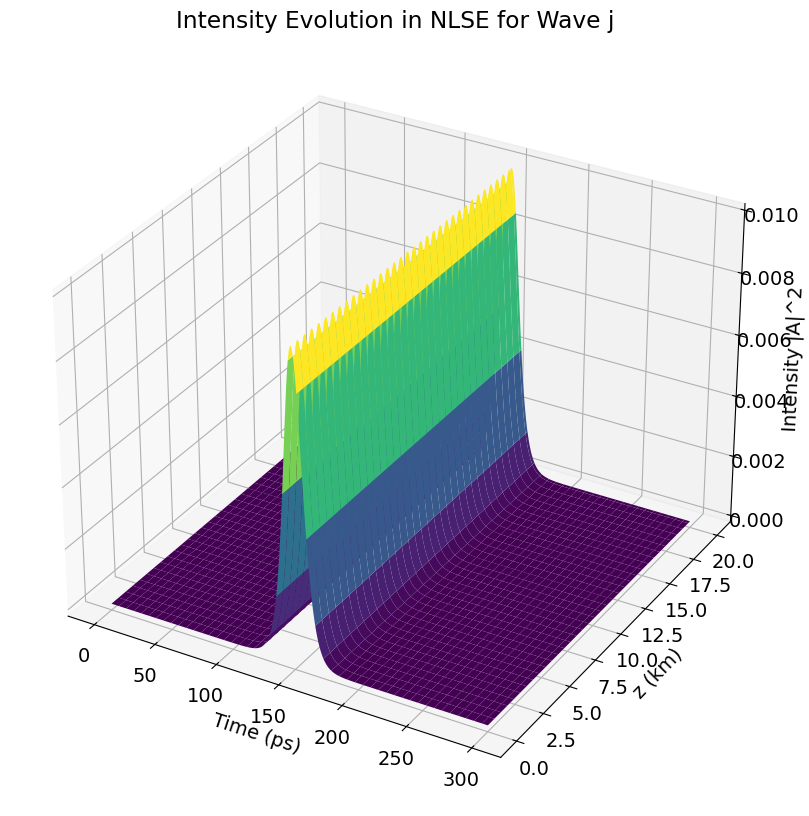

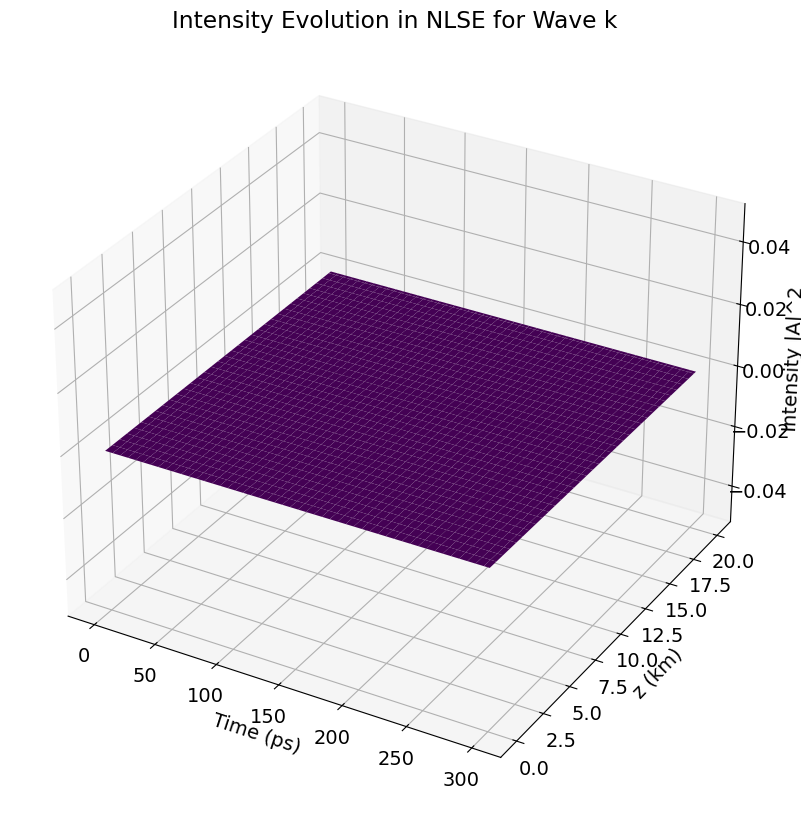

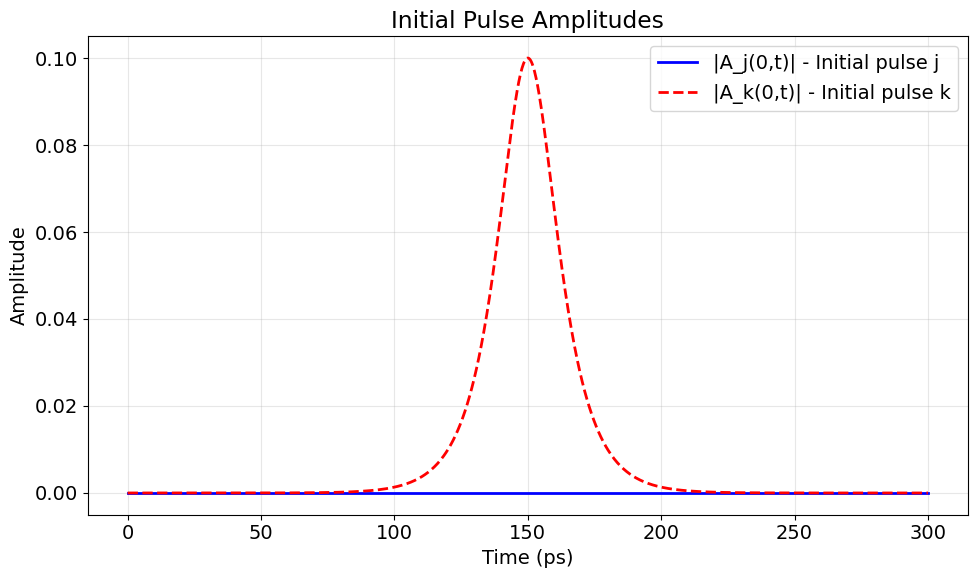

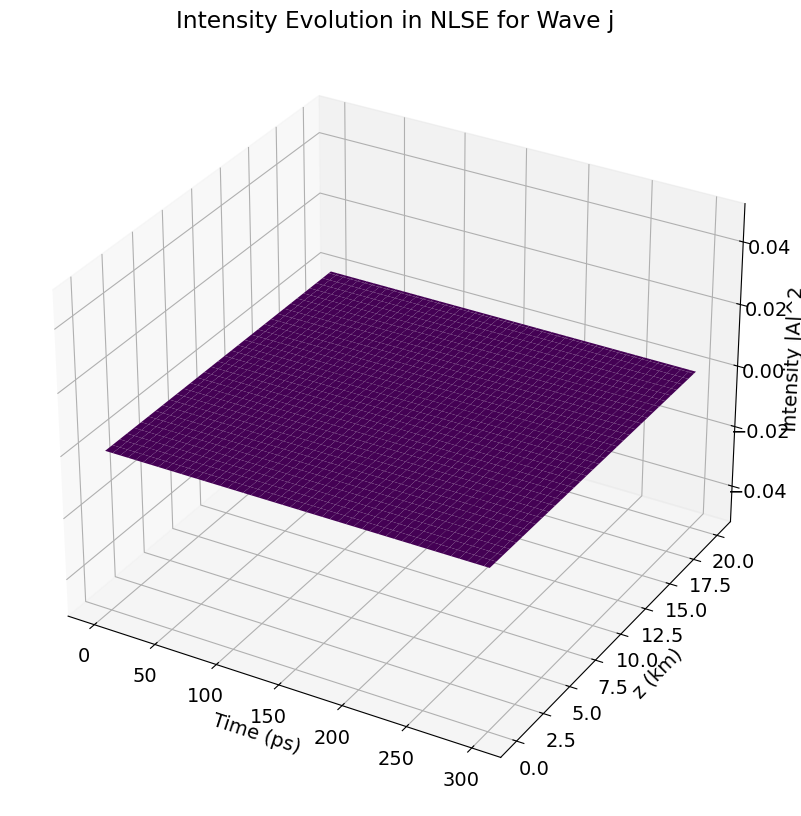

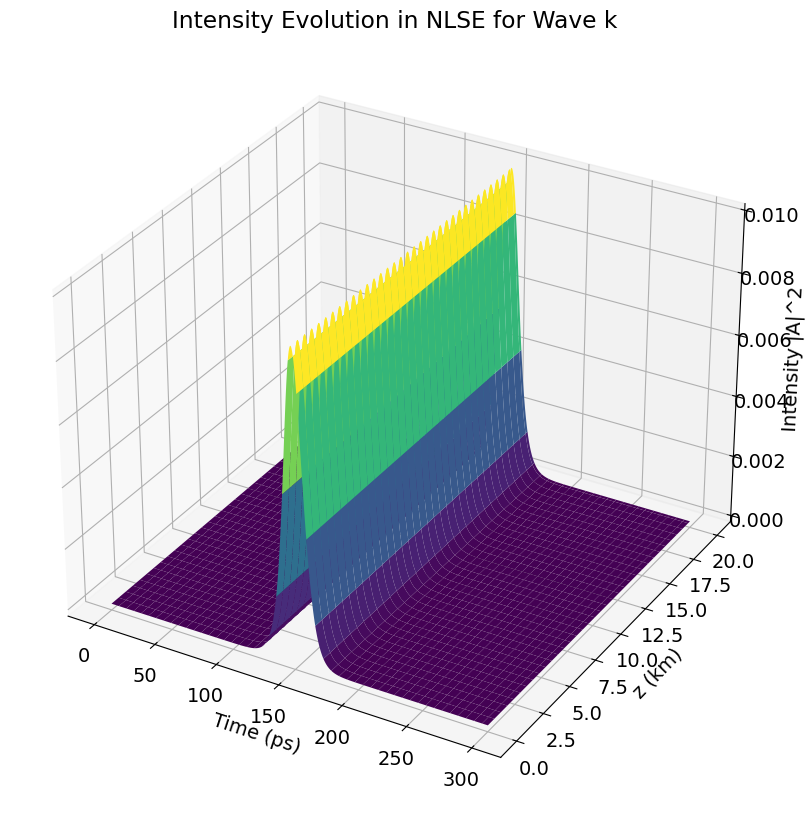

In [7]:
# Plot the initial pulses 1
plt.figure(figsize=(10, 6))
plt.plot(t, torch.abs(Ain_j1), 'b-', linewidth=2, label='|A_j(0,t)| - Initial pulse j')
plt.plot(t, torch.abs(Ain_k1), 'r--', linewidth=2, label='|A_k(0,t)| - Initial pulse k')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Initial Pulse Amplitudes')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# plot intensity evolution 1
plot_intensity_evolution(A_j_evolution1, t, Lz, Nz, wave_name='Wave j')
plot_intensity_evolution(A_k_evolution1, t, Lz, Nz, wave_name='Wave k')

# Plot the initial pulses 2
plt.figure(figsize=(10, 6))
plt.plot(t, torch.abs(Ain_j2), 'b-', linewidth=2, label='|A_j(0,t)| - Initial pulse j')
plt.plot(t, torch.abs(Ain_k2), 'r--', linewidth=2, label='|A_k(0,t)| - Initial pulse k')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Initial Pulse Amplitudes')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# plot intensity evolution 1
plot_intensity_evolution(A_j_evolution2, t, Lz, Nz, wave_name='Wave j')
plot_intensity_evolution(A_k_evolution2, t, Lz, Nz, wave_name='Wave k')

## **Bright-Dark Soliton Pair Simulation**

Questions:
1. What is the distance we want to use
2. What did you do with boundary effects
3. What are okay W, omega_j, omega_k, v_g parameters?

### Parameters

In [8]:
# define simulation parameters
Lz = 1               # Propagation distance in km (1cm = 1e-5)
Nz = 1000              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 100            # Temporal window size
Nt = 4096               # Number of temporal points

# define medium parameters
beta2_j = -20           # anomalous GVD region
beta2_k = 20           # normal GVD region
gamma_j = 20
gamma_k = 20

# define soliton parameters
W = 0.4
omega_j = 0.1
omega_k = -0.1
v_g = 3e-7 # km/ps

### Simulation
The bright-dark soliton pair solution is given by:
 
$$A_j(z,t) = B_1 \tanh[W(t - z/V)] \exp[i(K_1 z - \Omega_j t)]$$
 
$$A_k(z,t) = B_2 \text{sech}[W(t - z/V)] \exp[i(K_2 z - \Omega_k t)]$$

where the soliton amplitudes are determined from:
 
$$B_1^2 = \frac{(2\gamma_j \beta_{2k} + \gamma_k |\beta_{2j}|) W^2}{3\gamma_j \gamma_k}$$
 
$$B_2^2 = \frac{(2\gamma_k |\beta_{2j}| + \gamma_j \beta_{2k}) W^2}{3\gamma_j \gamma_k}$$
 
the wave numbers $K_1$ and $K_2$ are given by:
 
$$K_1 = \gamma_j B_1^2 - \frac{|\beta_{2j}| \Omega_j^2}{2}, \quad K_2 = \frac{\beta_{2k} (\Omega_k^2 - W^2)}{2}$$
 
and the effective group velocity of the soliton pair is obtained from:
 
$$V^{-1} = v_g^{-1} - |\beta_{2j}| \Omega_j = v_g^{-1} + \beta_{2k} \Omega_k$$


In [9]:
# calculate downstream parameters from the given equations
B1 = ((2*gamma_j*beta2_k + gamma_k* np.abs(beta2_j)) * W**2 / (3*gamma_j*gamma_k))**(0.5)
B2 = ((2*gamma_k* np.abs(beta2_j) + gamma_j*beta2_k) * W**2 / (3*gamma_j*gamma_k))**(0.5)

# calculate wave numbers K1 and K2
K1 = gamma_j * B1**2 - np.abs(beta2_j)* omega_j**2 / 2
K2 = beta2_k * (omega_k**2 - W**2) / 2

# calculate group velocities V1 and V2
V_inv = (v_g**(-1) - np.abs(beta2_j) * omega_j)

# define waveforms
t = torch.linspace(-Lt/2, Lt/2, Nt)  # Temporal grid (only positive times)
Ain_j = B1 * torch.tanh(W * (t - 0*V_inv)) 
Ain_k = B2 * (1/torch.cosh(W * (t - 0*V_inv)))

# run simulation
A_j_evolution, A_k_evolution  = split_step_fourier_xpm(Ain_j, Ain_k, dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)

In [10]:
# testing
print(A_j_evolution.shape)

torch.Size([4096, 1001])


### Plotting

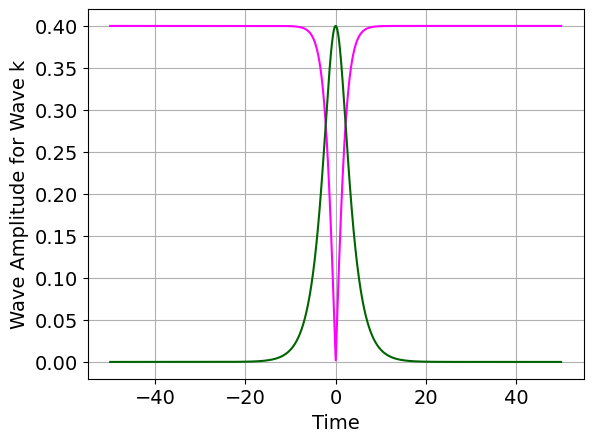

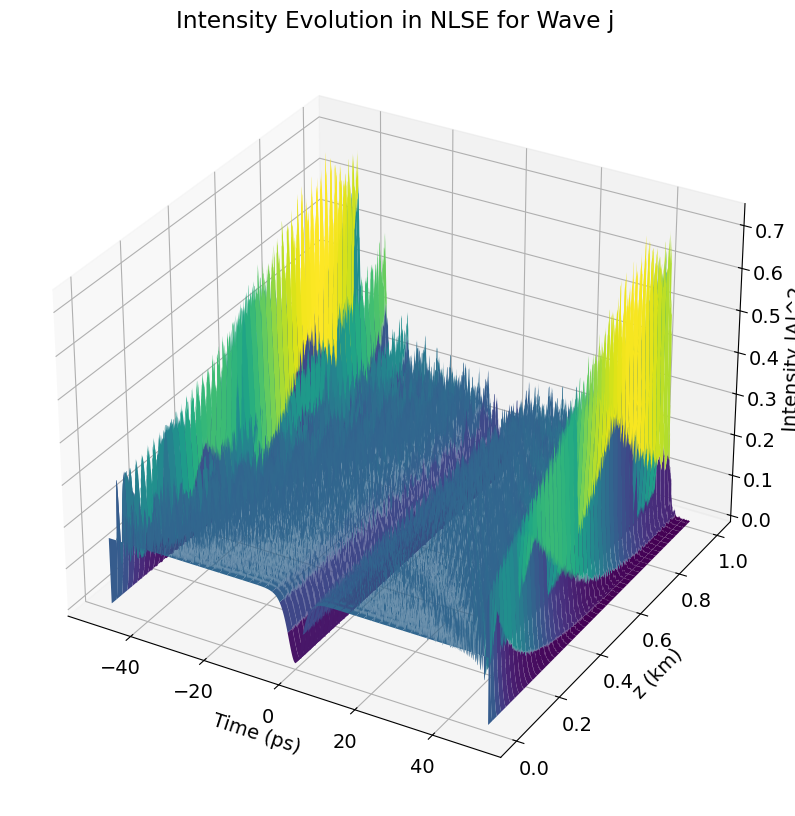

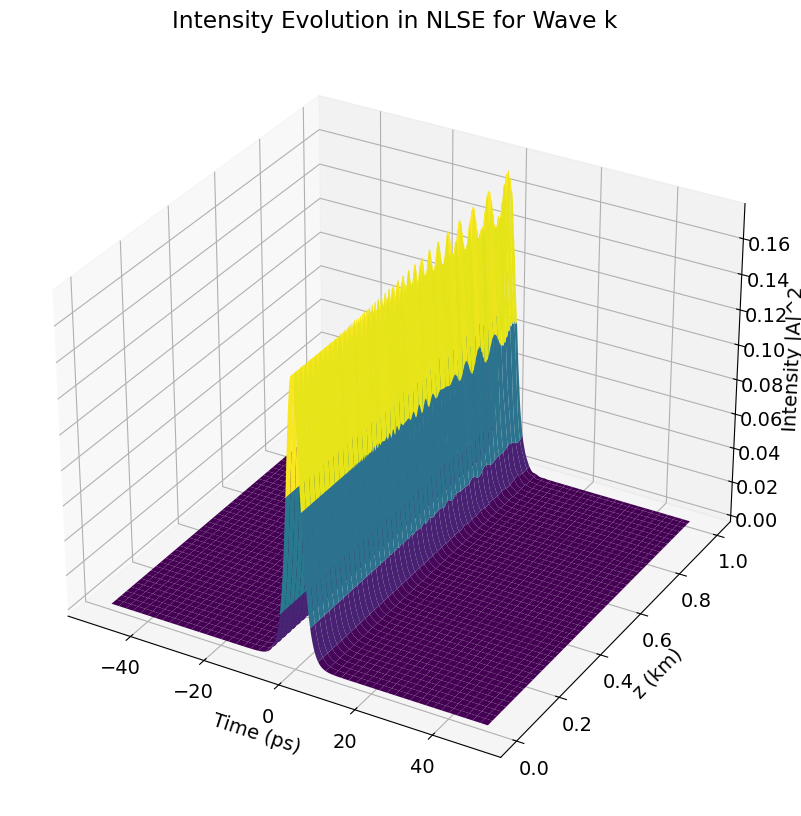

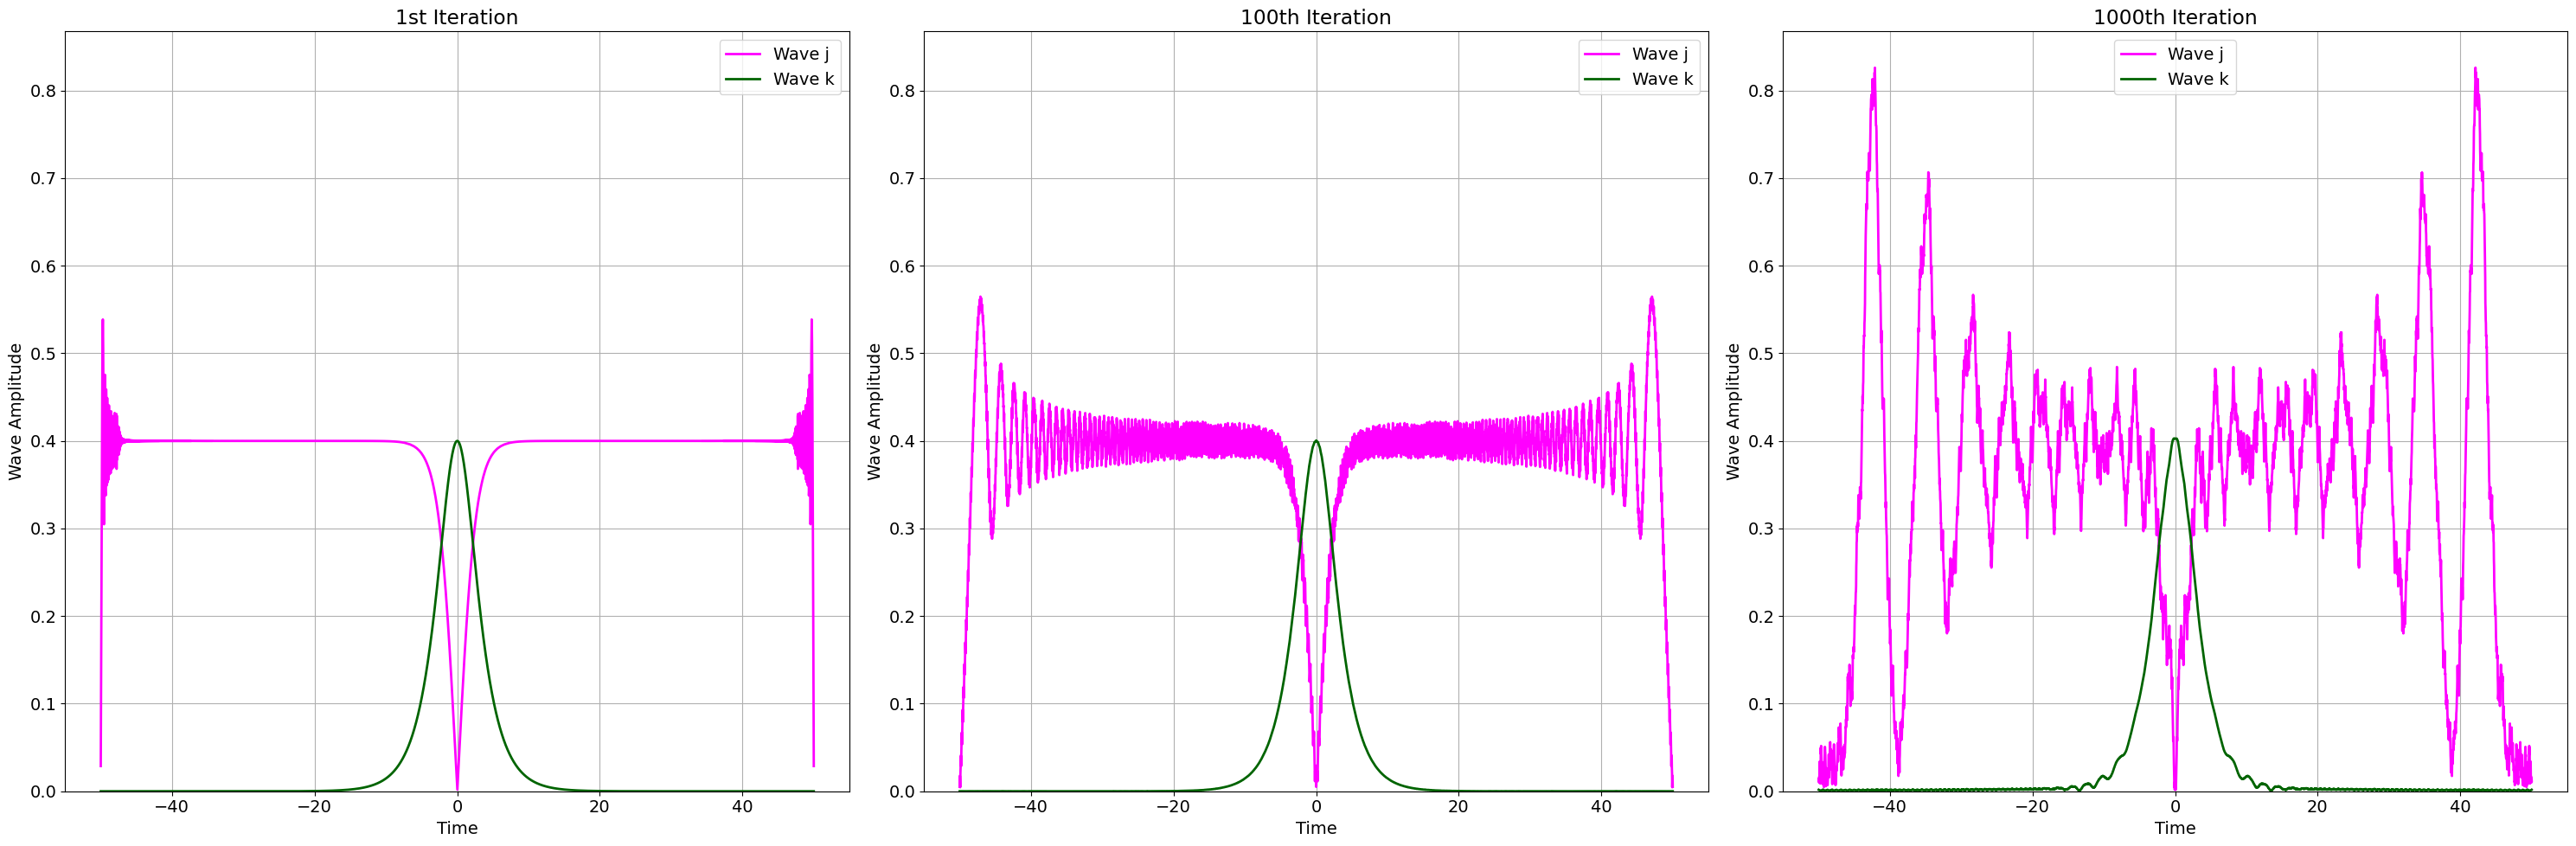

In [11]:
# plot input waveforms
plt.plot(t, torch.abs(Ain_j), color='magenta', label = 'Wave Amplitude for Wave j')
plt.plot(t, torch.abs(Ain_k), color = 'darkgreen', label = 'Wave Amplitude for Wave k')
plt.xlabel('Time')
plt.ylabel('Wave Amplitude for Wave k')
plt.grid()

# plot intensity evolution
plot_intensity_evolution(A_j_evolution, t, Lz, Nz, wave_name='Wave j')
plot_intensity_evolution(A_k_evolution, t, Lz, Nz, wave_name='Wave k')

# plot evolution at specific iterations (2nd, 3rd, 4th) for both waves
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

iterations = [1, 100, 1000]  # 2nd, 3rd, 4th elements (0-indexed)
iteration_labels = ['1st', '100th', '1000th']

# Find global y-axis limits across all iterations
y_max = 0
for iter_idx in iterations:
    y_max = max(y_max, torch.max(torch.abs(A_j_evolution[:, iter_idx])).item())
    y_max = max(y_max, torch.max(torch.abs(A_k_evolution[:, iter_idx])).item())

for idx, (iter_idx, iter_label) in enumerate(zip(iterations, iteration_labels)):
    axes[idx].plot(t, torch.abs(A_j_evolution[:, iter_idx]), color='magenta', label='Wave j', linewidth=2)
    axes[idx].plot(t, torch.abs(A_k_evolution[:, iter_idx]), color='darkgreen', label='Wave k', linewidth=2)
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Wave Amplitude')
    axes[idx].set_title(f'{iter_label} Iteration')
    axes[idx].set_ylim(0, y_max * 1.05)  # Set same y-scale for all subplots with 5% padding
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()


Notes:
1. Increasing lenght of window helps, since "the oscillations" are more toward the edges and don't effect the window itself
2. increasing Nt also helps


## **Bright-Bright Soliton Pair Simulation**

### Parameters

In [19]:
# define simulation parameters
Lz = 2e-2               # Propagation distance in km (1cm = 1e-5)
r = 2e5 # ratio of steps/km = Nz/Lz (the higher this is, the more accurate the simulation will be) - an okay empirical value is 2e5
Nz = int(r * Lz)             # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 2           # Temporal window size
Nt = 4096               # Number of temporal points

# define medium parameters
beta2_j = -20           # anomalous GVD region
beta2_k = -25           # normal GVD region
gamma_j = 20
gamma_k = 20

# define soliton parameters
tau = 0.05 # ps
theta_j = 0
theta_k = 0
f = 1

### Simulation
Assuming both pulses $j = 1, 2$ have the shape
 
$$A_j = a_j \text{sech}\left(\frac{t}{\tau}\right) e^{i\theta_j t},$$
We can show that soliton pair solution can exist if

$$a_1^2 = \frac{-2f\frac{\beta_2^{(k)}}{\gamma_k} + \frac{\beta_2^{(j)}}{\gamma_j}}{\tau^2(4f^2 - 1)},$$ 
$$a_2^2 = \frac{-2f\frac{\beta_2^{(j)}}{\gamma_j} + \frac{\beta_2^{(k)}}{\gamma_k}}{\tau^2(4f^2 - 1)}.$$


In [20]:
# Calculate soliton amplitudes using the bright-bright soliton pair conditions
a1_squared = (-2*f*(beta2_k/gamma_k) + (beta2_j/gamma_j)) / (tau**2 * (4*f**2 - 1))
a2_squared = (-2*f*(beta2_j/gamma_j) + (beta2_k/gamma_k)) / (tau**2 * (4*f**2 - 1))

# #! override for test
# a1_squared = 100

# Take square root to get amplitudes (assuming positive real values)
a1 = np.sqrt(a1_squared)
a2 = np.sqrt(a2_squared)

print(f"Soliton amplitude a1 = {a1:.4f}")
print(f"Soliton amplitude a2 = {a2:.4f}")
print(f"a1^2 = {a1_squared:.4f}")
print(f"a2^2 = {a2_squared:.4f}")

# define waveforms
t = torch.linspace(-Lt/2, Lt/2, Nt)  # Temporal grid (only positive times)

# Define initial waveforms using the soliton formula A_j = a_j * sech(t/tau) * exp(i*theta_j*t)
Ain_j = a1 * torch.cosh(t / tau)**(-1) * torch.exp(1j * theta_j * t)
Ain_k = a2 * torch.cosh(t / tau)**(-1) * torch.exp(1j * theta_k * t)

# run simulation
A_j_evolution, A_k_evolution  = split_step_fourier_xpm(Ain_j, Ain_k, dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)


Soliton amplitude a1 = 14.1421
Soliton amplitude a2 = 10.0000
a1^2 = 200.0000
a2^2 = 100.0000


### Plotting

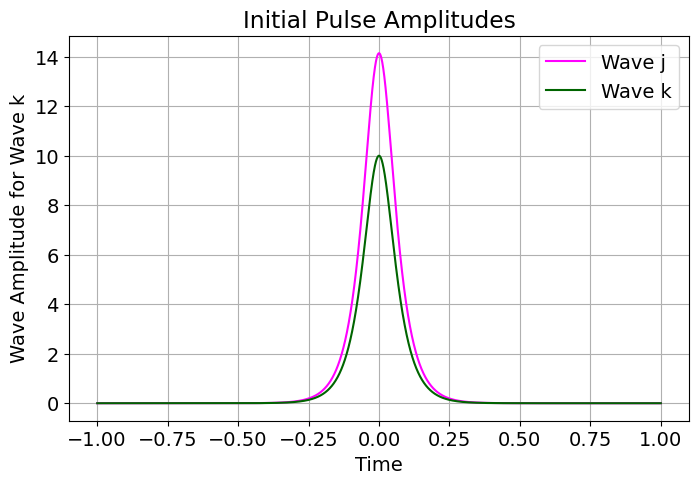

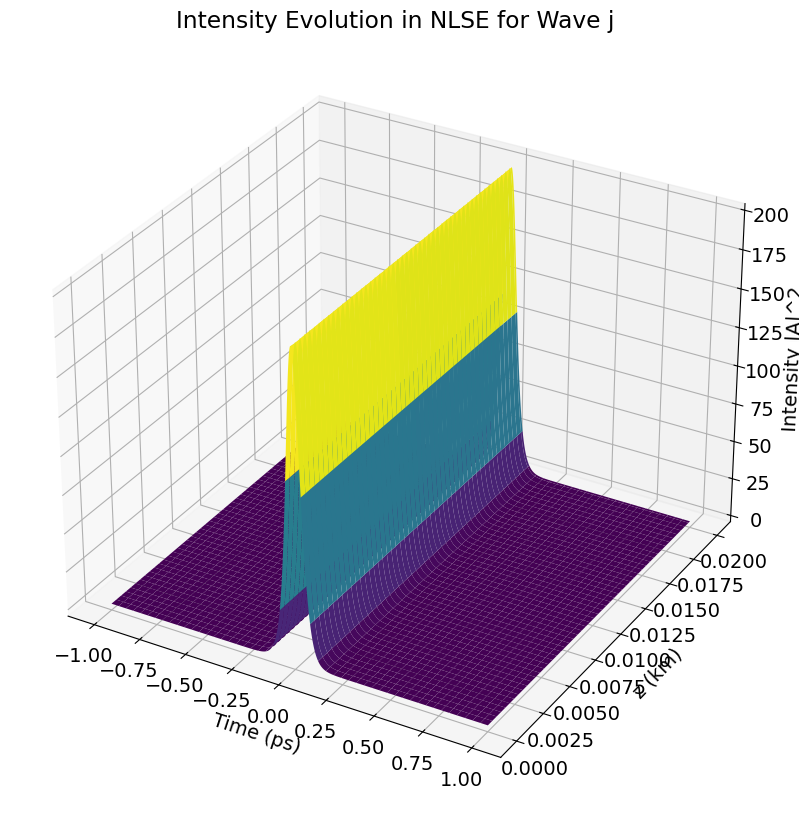

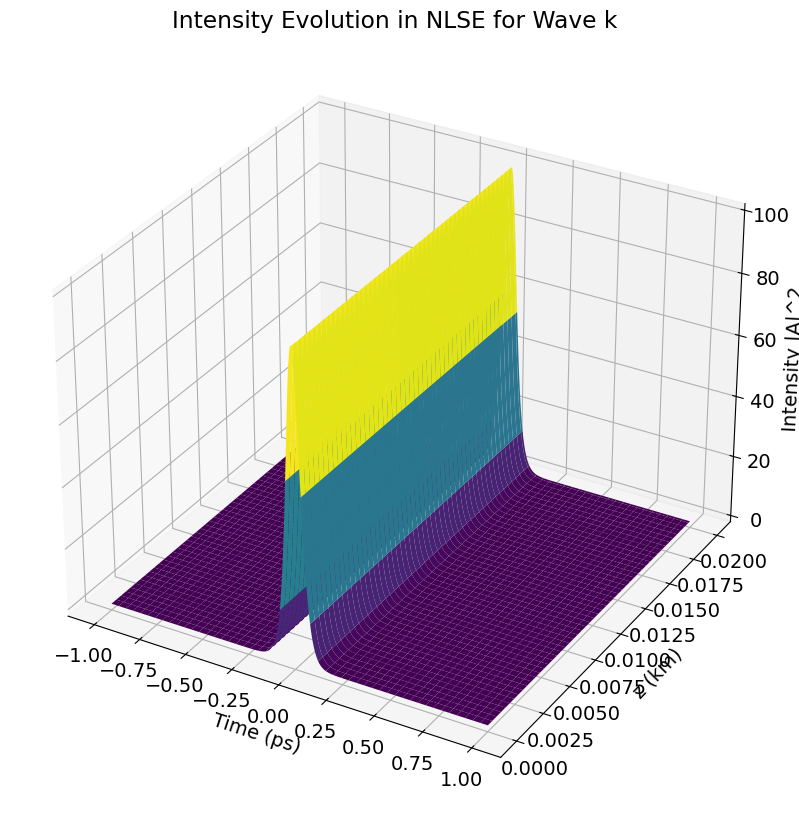

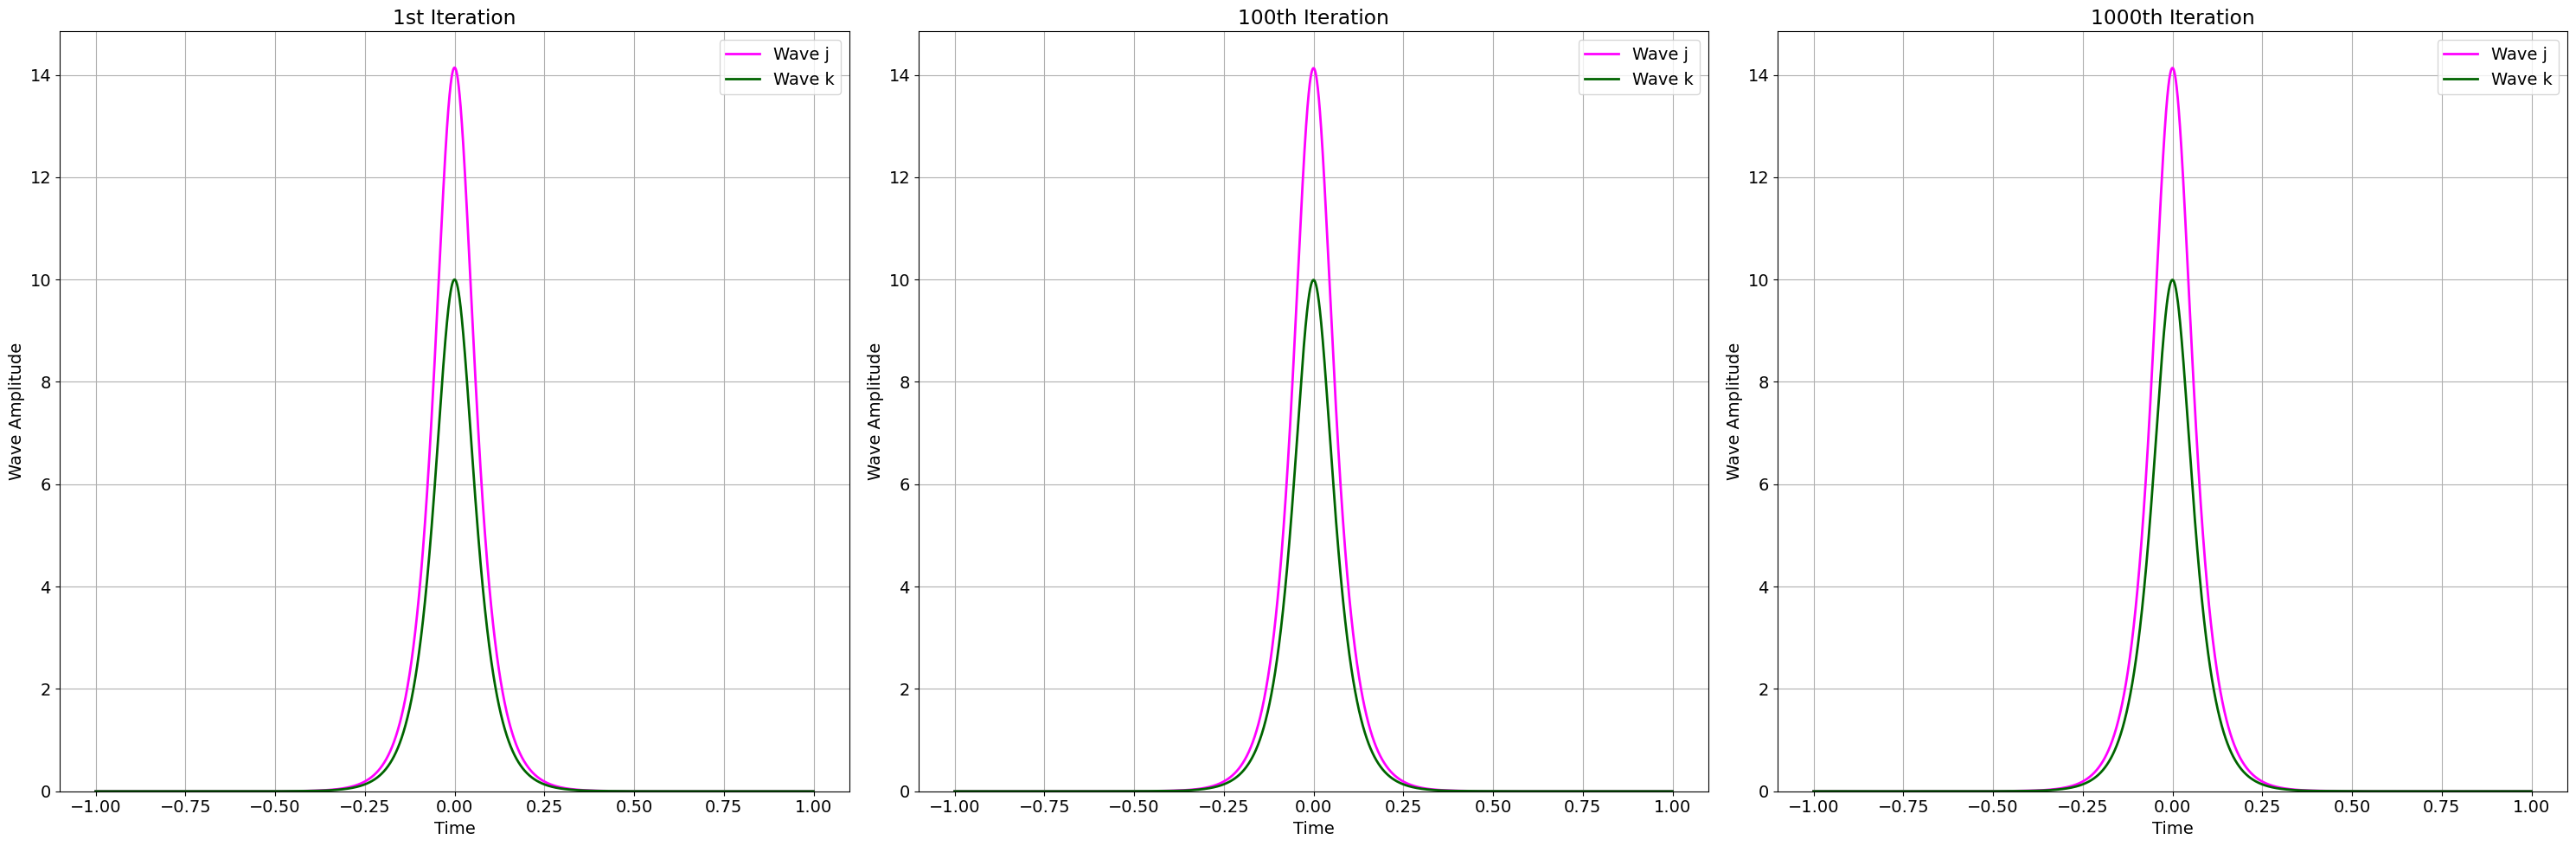

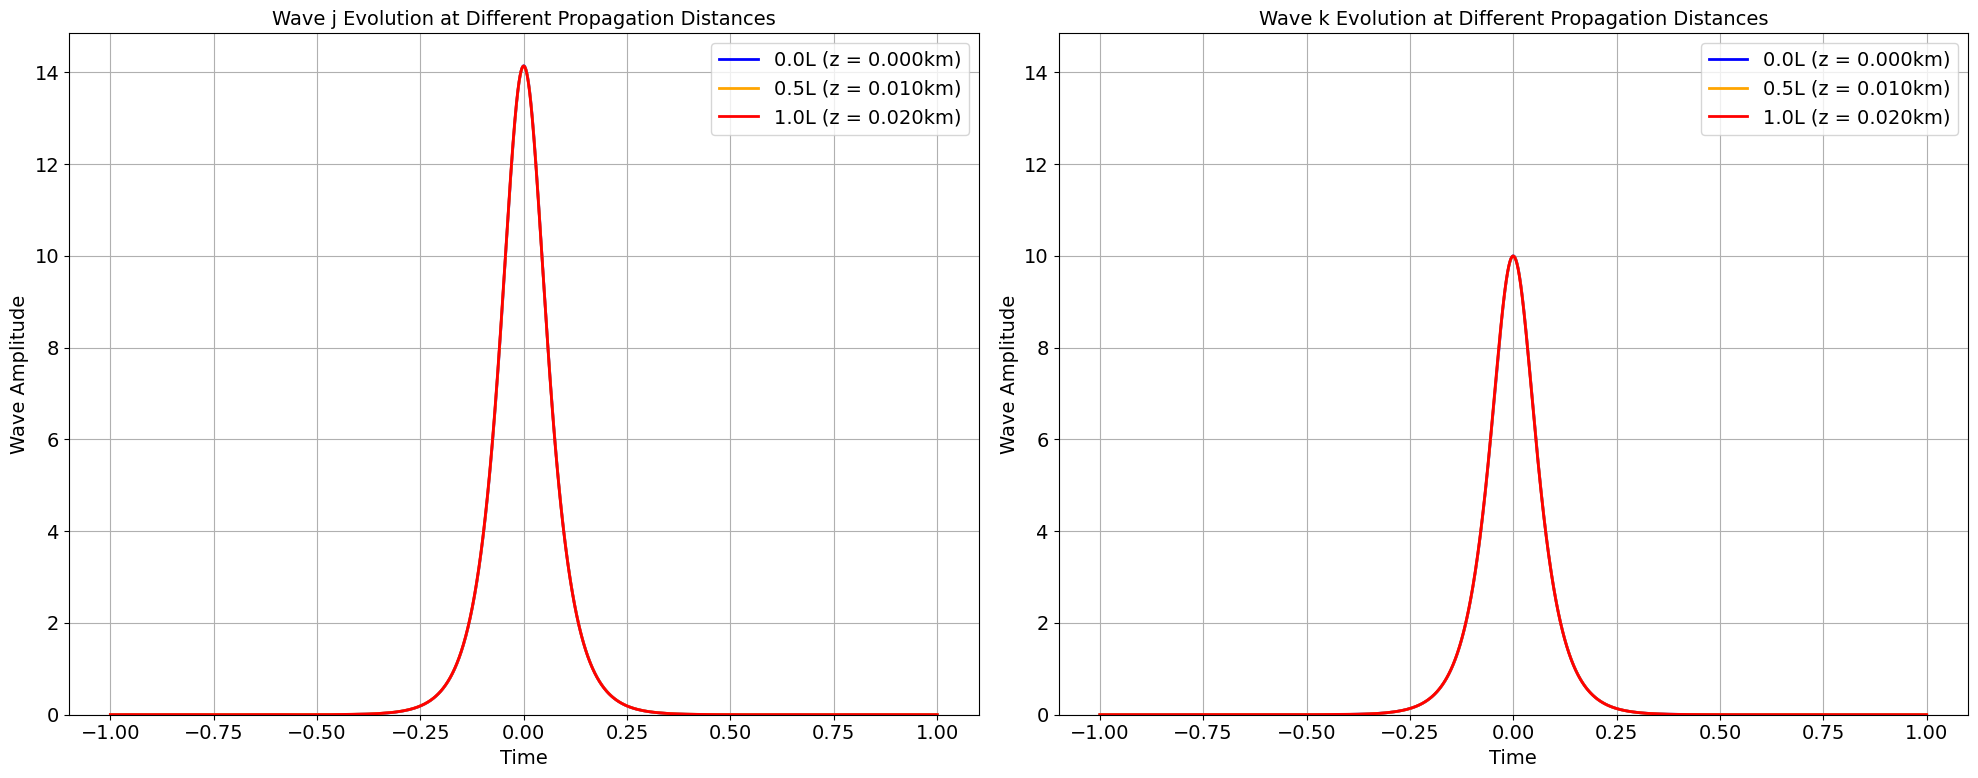

In [27]:
# plot input waveforms
plt.figure(figsize=(8, 5))
plt.title("Initial Pulse Amplitudes")
plt.plot(t, torch.abs(Ain_j), color='magenta', label = 'Wave j')
plt.plot(t, torch.abs(Ain_k), color = 'darkgreen', label = 'Wave k')
plt.xlabel('Time')
plt.ylabel('Wave Amplitude for Wave k')
plt.legend()
plt.grid()

# plot intensity evolution
plot_intensity_evolution(A_j_evolution, t, Lz, Nz, wave_name='Wave j')
plot_intensity_evolution(A_k_evolution, t, Lz, Nz, wave_name='Wave k')

# plot evolution at specific iterations (2nd, 3rd, 4th) for both waves
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

iterations = [1, 100, 1000]  # 2nd, 3rd, 4th elements (0-indexed)
iteration_labels = ['1st', '100th', '1000th']

# Find global y-axis limits across all iterations
y_max = 0
for iter_idx in iterations:
    y_max = max(y_max, torch.max(torch.abs(A_j_evolution[:, iter_idx])).item())
    y_max = max(y_max, torch.max(torch.abs(A_k_evolution[:, iter_idx])).item())

for idx, (iter_idx, iter_label) in enumerate(zip(iterations, iteration_labels)):
    axes[idx].plot(t, torch.abs(A_j_evolution[:, iter_idx]), color='magenta', label='Wave j', linewidth=2)
    axes[idx].plot(t, torch.abs(A_k_evolution[:, iter_idx]), color='darkgreen', label='Wave k', linewidth=2)
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Wave Amplitude')
    axes[idx].set_title(f'{iter_label} Iteration')
    axes[idx].set_ylim(0, y_max * 1.05)  # Set same y-scale for all subplots with 5% padding
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()

# plot evolution at specific propagation distances (0, 0.5, 1.0 relative distance)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Define propagation distances as fractions of total distance
distances = [0, 0.5, 1.0]
distance_indices = [int(frac * (Nz - 1)) for frac in distances]
distance_labels = [f'{frac:.1f}L (z = {frac * Lz:.3f}km)' for frac in distances]
colors = ['blue', 'orange', 'red']

# Find global y-axis limits across all distances for both waves
y_max = 0
for dist_idx in distance_indices:
    y_max = max(y_max, torch.max(torch.abs(A_j_evolution[:, dist_idx])).item())
    y_max = max(y_max, torch.max(torch.abs(A_k_evolution[:, dist_idx])).item())

# Plot Wave j evolution
axes[0].set_title('Wave j Evolution at Different Propagation Distances', fontsize=14)
for idx, (dist_idx, dist_label, color) in enumerate(zip(distance_indices, distance_labels, colors)):
    axes[0].plot(t, torch.abs(A_j_evolution[:, dist_idx]), color=color, label=dist_label, linewidth=2)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Wave Amplitude')
axes[0].set_ylim(0, y_max * 1.05)  # Set shared y-scale with 5% padding
axes[0].grid(True)
axes[0].legend()

# Plot Wave k evolution
axes[1].set_title('Wave k Evolution at Different Propagation Distances', fontsize=14)
for idx, (dist_idx, dist_label, color) in enumerate(zip(distance_indices, distance_labels, colors)):
    axes[1].plot(t, torch.abs(A_k_evolution[:, dist_idx]), color=color, label=dist_label, linewidth=2)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Wave Amplitude')
axes[1].set_ylim(0, y_max * 1.05)  # Set shared y-scale with 5% padding
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


### Accurracy Testing
*We aim to find the smallest r for which error of numerical method is still acceptable*

In [15]:
# # Define r values to test (steps per km)
# r_values = np.linspace(1e5, 1e4, 11)  # From 2e5 down to 1e5 in 11 steps
# baseline_r = 2e5
# mse_errors_strang = []
# mse_errors_no_strang = []

# # Run baseline simulation with r = 2e5
# Lz = 1e-2  # km
# Nz_baseline = int(baseline_r * Lz)
# dz_baseline = Lz / Nz_baseline

# # Define initial waveforms using the soliton formula A_j = a_j * sech(t/tau) * exp(i*theta_j*t)
# Ain_j = a1 * torch.cosh(t / tau)**(-1) * torch.exp(1j * theta_j * t)
# Ain_k = a2 * torch.cosh(t / tau)**(-1) * torch.exp(1j * theta_k * t)

# # Run baseline simulation with Strang splitting
# print(f"Running baseline simulation with Strang splitting (r = {baseline_r:.0f})...")
# A_j_baseline, A_k_baseline = split_step_fourier_xpm(Ain_j, Ain_k, dz_baseline, Nz_baseline, beta2_j, beta2_k, gamma_j, gamma_k, Lt, strangsplitting=True)

# # Test different r values
# for r in r_values:
#     print(f"Testing r = {r:.0f} steps/km...")
    
#     # Calculate simulation parameters for this r
#     Nz_test = int(r * Lz)
#     dz_test = Lz / Nz_test
    
#     # Run test simulation with Strang splitting
#     A_j_test_strang, A_k_test_strang = split_step_fourier_xpm(Ain_j, Ain_k, dz_test, Nz_test, beta2_j, beta2_k, gamma_j, gamma_k, Lt, strangsplitting=True)
    
#     # Run test simulation without Strang splitting
#     A_j_test_no_strang, A_k_test_no_strang = split_step_fourier_xpm(Ain_j, Ain_k, dz_test, Nz_test, beta2_j, beta2_k, gamma_j, gamma_k, Lt, strangsplitting=False)
    
#     # Calculate MSE for Strang splitting case
#     A_j_final_baseline = A_j_baseline[:, -1]
#     A_k_final_baseline = A_k_baseline[:, -1]
#     A_j_final_test_strang = A_j_test_strang[:, -1]
#     A_k_final_test_strang = A_k_test_strang[:, -1]
    
#     mse_j_strang = torch.mean(torch.abs(A_j_final_baseline - A_j_final_test_strang)**2).item()
#     mse_k_strang = torch.mean(torch.abs(A_k_final_baseline - A_k_final_test_strang)**2).item()
#     total_mse_strang = mse_j_strang + mse_k_strang
    
#     # Calculate MSE for no Strang splitting case
#     A_j_final_test_no_strang = A_j_test_no_strang[:, -1]
#     A_k_final_test_no_strang = A_k_test_no_strang[:, -1]
    
#     mse_j_no_strang = torch.mean(torch.abs(A_j_final_baseline - A_j_final_test_no_strang)**2).item()
#     mse_k_no_strang = torch.mean(torch.abs(A_k_final_baseline - A_k_final_test_no_strang)**2).item()
#     total_mse_no_strang = mse_j_no_strang + mse_k_no_strang
    
#     mse_errors_strang.append(total_mse_strang)
#     mse_errors_no_strang.append(total_mse_no_strang)
    
#     print(f"  Strang: MSE_j = {mse_j_strang:.2e}, MSE_k = {mse_k_strang:.2e}, Total MSE = {total_mse_strang:.2e}")
#     print(f"  No Strang: MSE_j = {mse_j_no_strang:.2e}, MSE_k = {mse_k_no_strang:.2e}, Total MSE = {total_mse_no_strang:.2e}")

# # Plot MSE vs r for both methods - log scale
# plt.figure(figsize=(10, 6))
# plt.plot(r_values, mse_errors_strang, 'bo-', linewidth=2, markersize=8, label='Strang Splitting')
# plt.plot(r_values, mse_errors_no_strang, 'ro-', linewidth=2, markersize=8, label='No Strang Splitting')
# plt.xlabel('r (steps per km)', fontsize=12)
# plt.ylabel('Total MSE (log scale)', fontsize=12)
# plt.title('Numerical Accuracy vs Step Size\n(MSE between baseline r=2e5 with Strang splitting and test r values)', fontsize=14)
# plt.yscale('log')
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()

# # Add text annotation with baseline info
# plt.text(0.02, 0.98, f'Baseline: r = {baseline_r:.0f} steps/km (Strang splitting)', 
#          transform=plt.gca().transAxes, fontsize=10, 
#          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# # Plot MSE vs r for both methods - standard scale
# plt.figure(figsize=(10, 6))
# plt.plot(r_values, mse_errors_strang, 'bo-', linewidth=2, markersize=8, label='Strang Splitting')
# plt.plot(r_values, mse_errors_no_strang, 'ro-', linewidth=2, markersize=8, label='No Strang Splitting')
# plt.xlabel('r (steps per km)', fontsize=12)
# plt.ylabel('Total MSE', fontsize=12)
# plt.title('Numerical Accuracy vs Step Size\n(MSE between baseline r=2e5 with Strang splitting and test r values)', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()

# # Add text annotation with baseline info
# plt.text(0.02, 0.98, f'Baseline: r = {baseline_r:.0f} steps/km (Strang splitting)', 
#          transform=plt.gca().transAxes, fontsize=10, 
#          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# plt.show()


Notes: 
- if Lz and Nz is not balanced enough get "scrambling" (for example if Nz = 2000 and Lz = 1e-1) 

## **Soliton Trapping of Weak Pulses**

If $|A_2| >> |A_1|$ then we can write:
$$\frac{\partial A_1}{\partial z} + \frac{i\beta_1^{(2)}}{2} \frac{\partial^2 A_1}{\partial t^2} = i\gamma_1 2f|A_2|^2 A_1,$$
 
$$\frac{\partial A_2}{\partial z} + \frac{i\beta_2^{(2)}}{2} \frac{\partial^2 A_2}{\partial t^2} = i\gamma_2 |A_2|^2 A_2.$$

Since the second equation only includes SPM we can see that $A_2$ can form a soliton just as in the "single" wave case:
$$A_2 = a_2 \, \text{sech}\!\left(\frac{t}{\tau}\right) e^{i \theta_2 z}$$
with $a_2^2 = -\frac{\beta_{22}}{\gamma_2 \tau^2}$ and $\theta_2 = -\frac{\beta_{22}}{2 \tau^2}$

If the **weak** pulse $A_1$ has the shape
$$
A_1 = a_1 \, \text{sech}^p\!\left(\frac{t}{\tau}\right) e^{i \theta_1 z},
$$
with
$$
p = \frac{1}{2} \left( -1 + \sqrt{1 + 16 \frac{\beta_2^{(2)} \, f \gamma_1}{\beta_1^{(2)} \, \gamma_2}} \, \right).
$$
and $\beta_{21}, \beta_{22} < 0$ then the weak wave is also a soliton. 
Here it's amplitude $a_1$ can take on arbitrary value as long as $a_1 << a_2$.

### Parameters

In [33]:
# define simulation parameters
Lz = 2e-2               # Propagation distance in km (1cm = 1e-5)
Nz = 2000
dz = Lz / Nz            # Step size in z
Lt = 2          # Temporal window size
Nt = 1024               # Number of temporal points

# define medium parameters
beta2_j = -20           # anomalous GVD region
beta2_k = -20           # anomalous GVD region
gamma_j = 20
gamma_k = 20

# define soliton parameters
tau = 0.05 # ps
f = 1 # overlap integral
amplitude_ratio = 100 # a_2 / a_1

### Simulation

In [34]:
# calculate secondary parameters
a_2_squared = -beta2_k / (gamma_k * tau**2)
a_2 = np.sqrt(a_2_squared)
theta_k = -beta2_k / (2 * tau**2)
a_1 = a_2 / amplitude_ratio

# For the weak pulse A_1 (soliton-like):
p = 0.5 * (-1 + np.sqrt(1 + 16 * beta2_k * f * gamma_j / (beta2_j * gamma_k)))

print(f"Strong pulse amplitude a_2 = {a_2:.4f}")
print(f"Strong pulse phase theta_2 = {theta_k:.4f}")
print(f"Weak pulse amplitude a_1 = {a_1:.4f}")
print(f"Weak pulse sech power p = {p:.4f}")

# define waveforms
t = torch.linspace(-Lt/2, Lt/2, Nt) 

# Define initial waveforms using the soliton formula A_j = a_j * sech(t/tau) * exp(i*theta_j*t)
Ain_j = a_1 * (torch.cosh(t / tau)**(-1))**p 
Ain_k = a_2 * torch.cosh(t / tau)**(-1)

# run simulation
A_j_evolution, A_k_evolution  = split_step_fourier_xpm(Ain_j, Ain_k, dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)


Strong pulse amplitude a_2 = 20.0000
Strong pulse phase theta_2 = 4000.0000
Weak pulse amplitude a_1 = 0.2000
Weak pulse sech power p = 1.5616


### Plotting

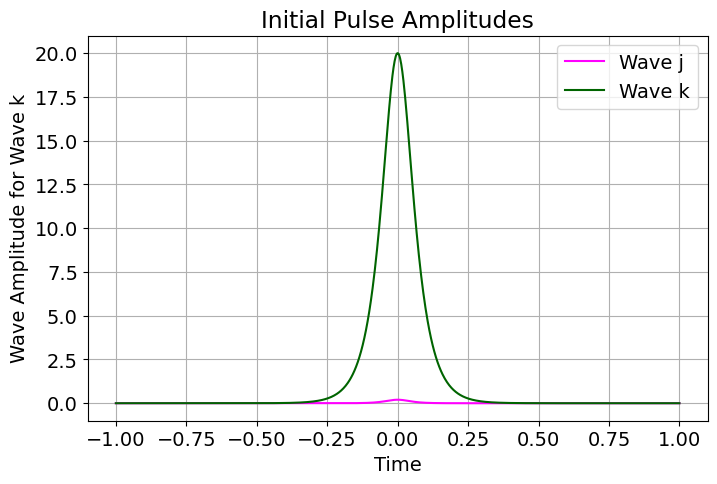

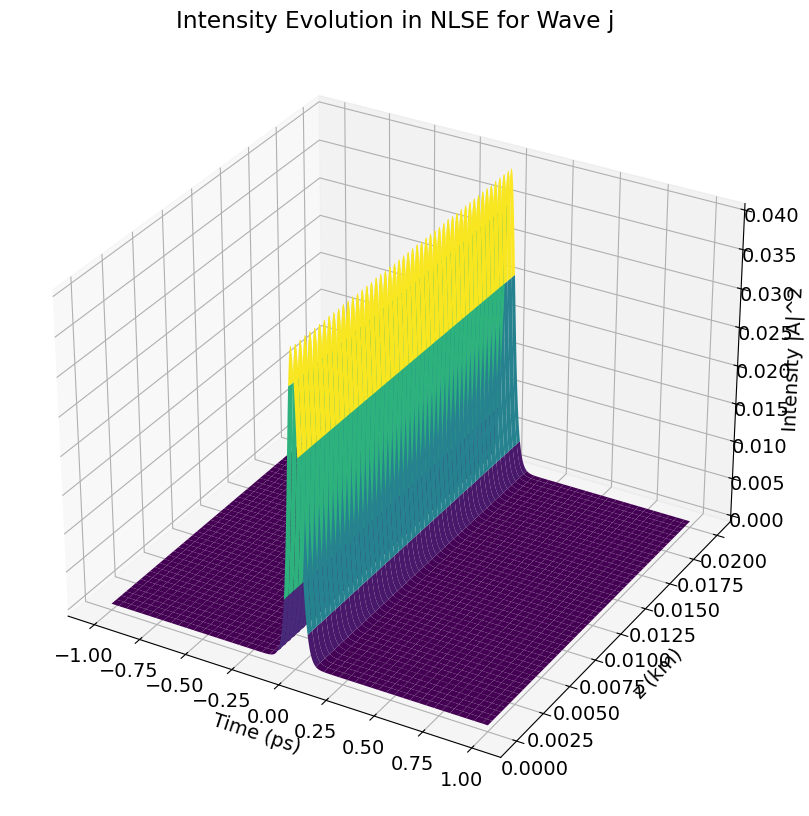

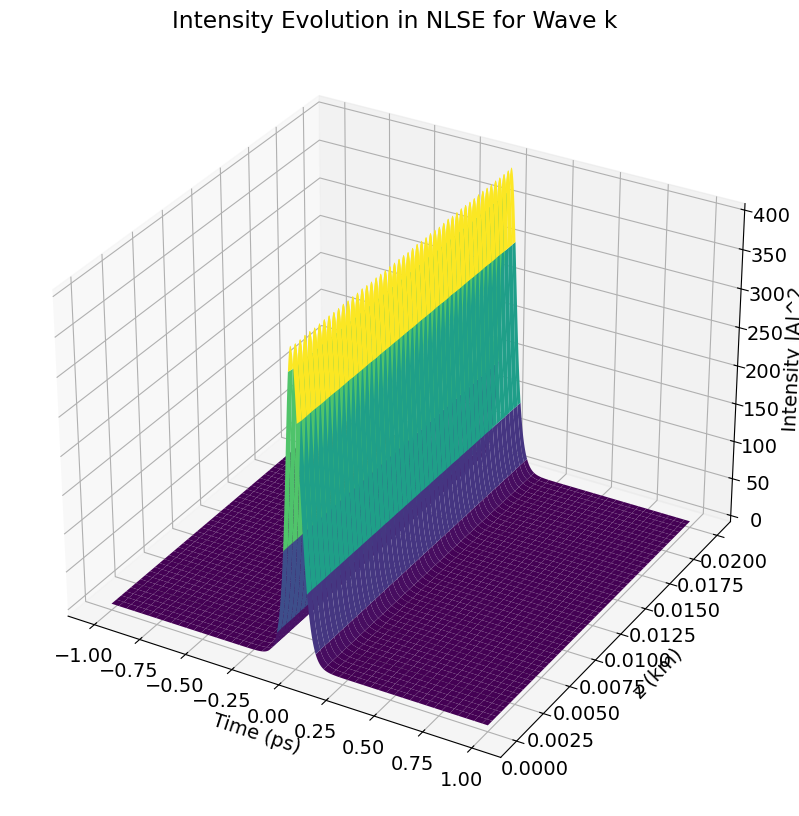

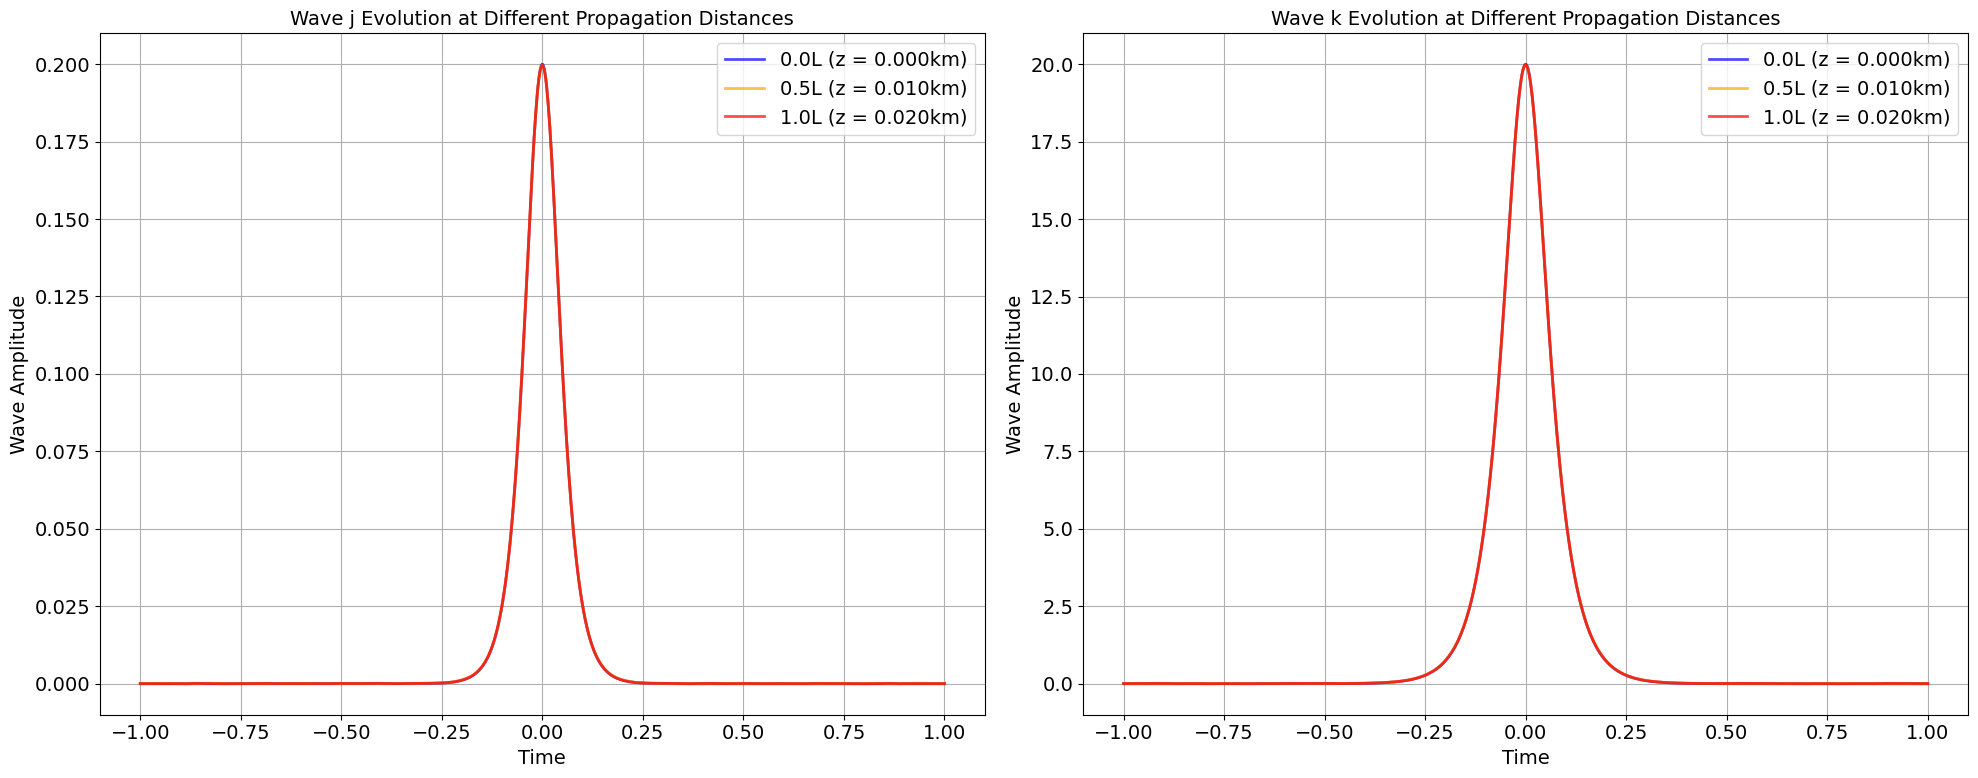

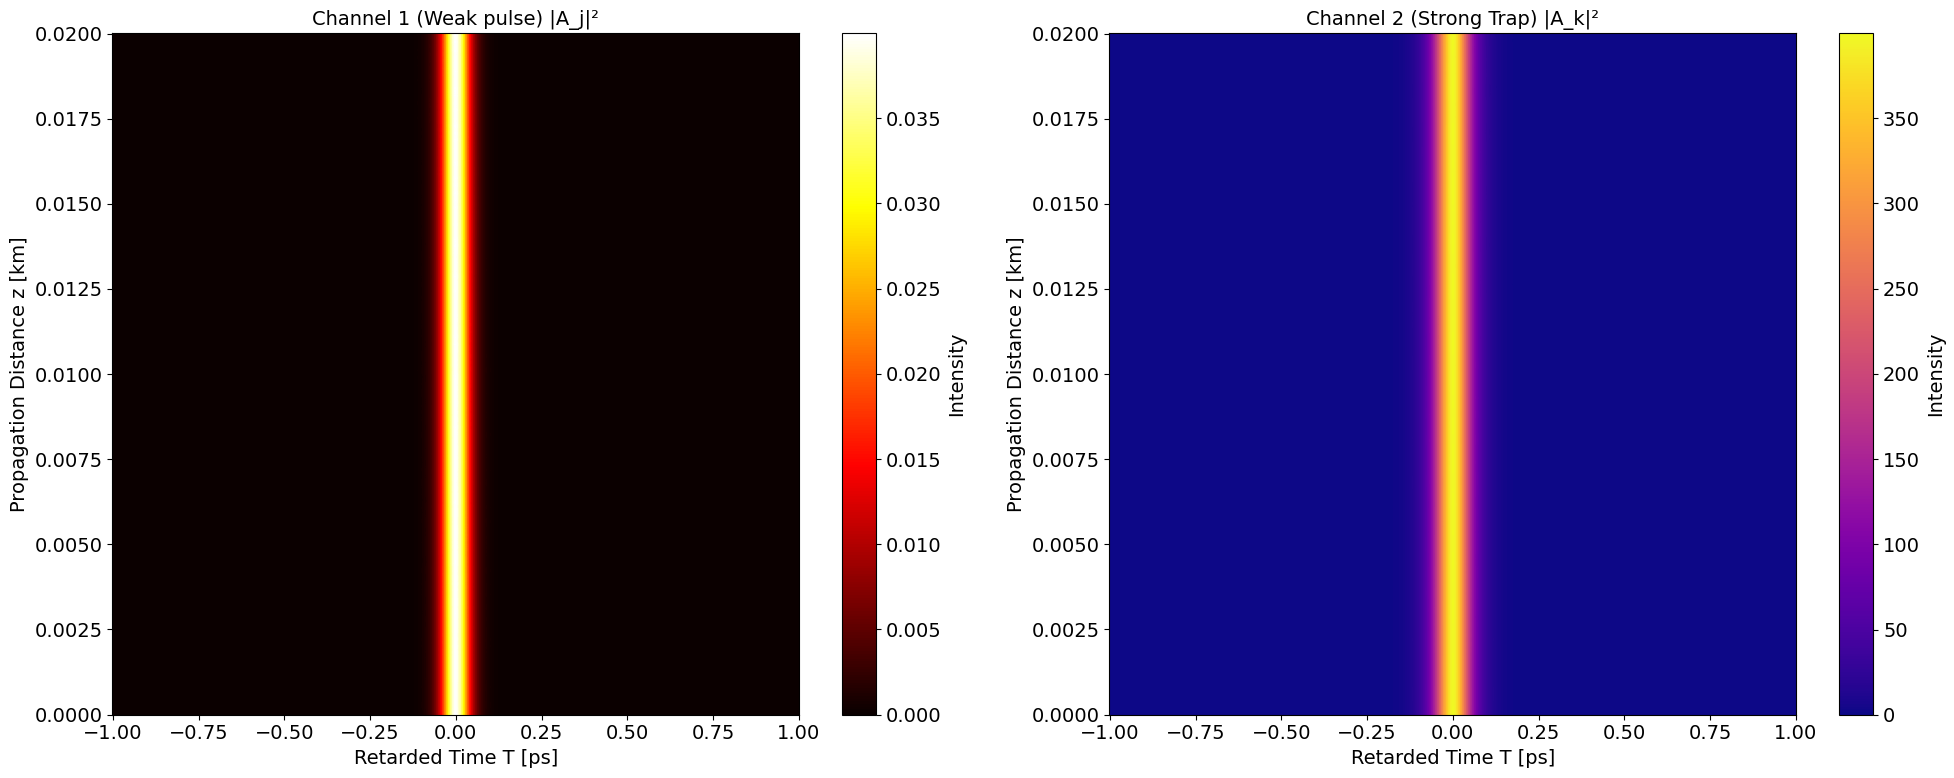

In [35]:
# plot input waveforms
plt.figure(figsize=(8, 5))
plt.title("Initial Pulse Amplitudes")
plt.plot(t, torch.abs(Ain_j), color='magenta', label = 'Wave j')
plt.plot(t, torch.abs(Ain_k), color = 'darkgreen', label = 'Wave k')
plt.xlabel('Time')
plt.ylabel('Wave Amplitude for Wave k')
plt.legend()
plt.grid()


# plot intensity evolution
plot_intensity_evolution(A_j_evolution, t, Lz, Nz, wave_name='Wave j')
plot_intensity_evolution(A_k_evolution, t, Lz, Nz, wave_name='Wave k')

# plot evolution at specific propagation distances (0, 0.5, 1.0 relative distance)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Define propagation distances as fractions of total distance
distances = [0, 0.5, 1.0]
distance_indices = [int(frac * (Nz - 1)) for frac in distances]
distance_labels = [f'{frac:.1f}L (z = {frac * Lz:.3f}km)' for frac in distances]
colors = ['blue', 'orange', 'red']


# Plot Wave j evolution
axes[0].set_title('Wave j Evolution at Different Propagation Distances', fontsize=14)
for idx, (dist_idx, dist_label, color) in enumerate(zip(distance_indices, distance_labels, colors)):
    axes[0].plot(t, torch.abs(A_j_evolution[:, dist_idx]), color=color, label=dist_label, linewidth=2, alpha=0.7)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Wave Amplitude')
axes[0].grid(True)
axes[0].legend()

# Plot Wave k evolution
axes[1].set_title('Wave k Evolution at Different Propagation Distances', fontsize=14)
for idx, (dist_idx, dist_label, color) in enumerate(zip(distance_indices, distance_labels, colors)):
    axes[1].plot(t, torch.abs(A_k_evolution[:, dist_idx]), color=color, label=dist_label, linewidth=2, alpha=0.7)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Wave Amplitude')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

# plot cowave evolution
plot_cowave_evolution(A_j_evolution, A_k_evolution, t, Lz, Nz)




### Absence Testing
*See what happens when we turn off one pulse*

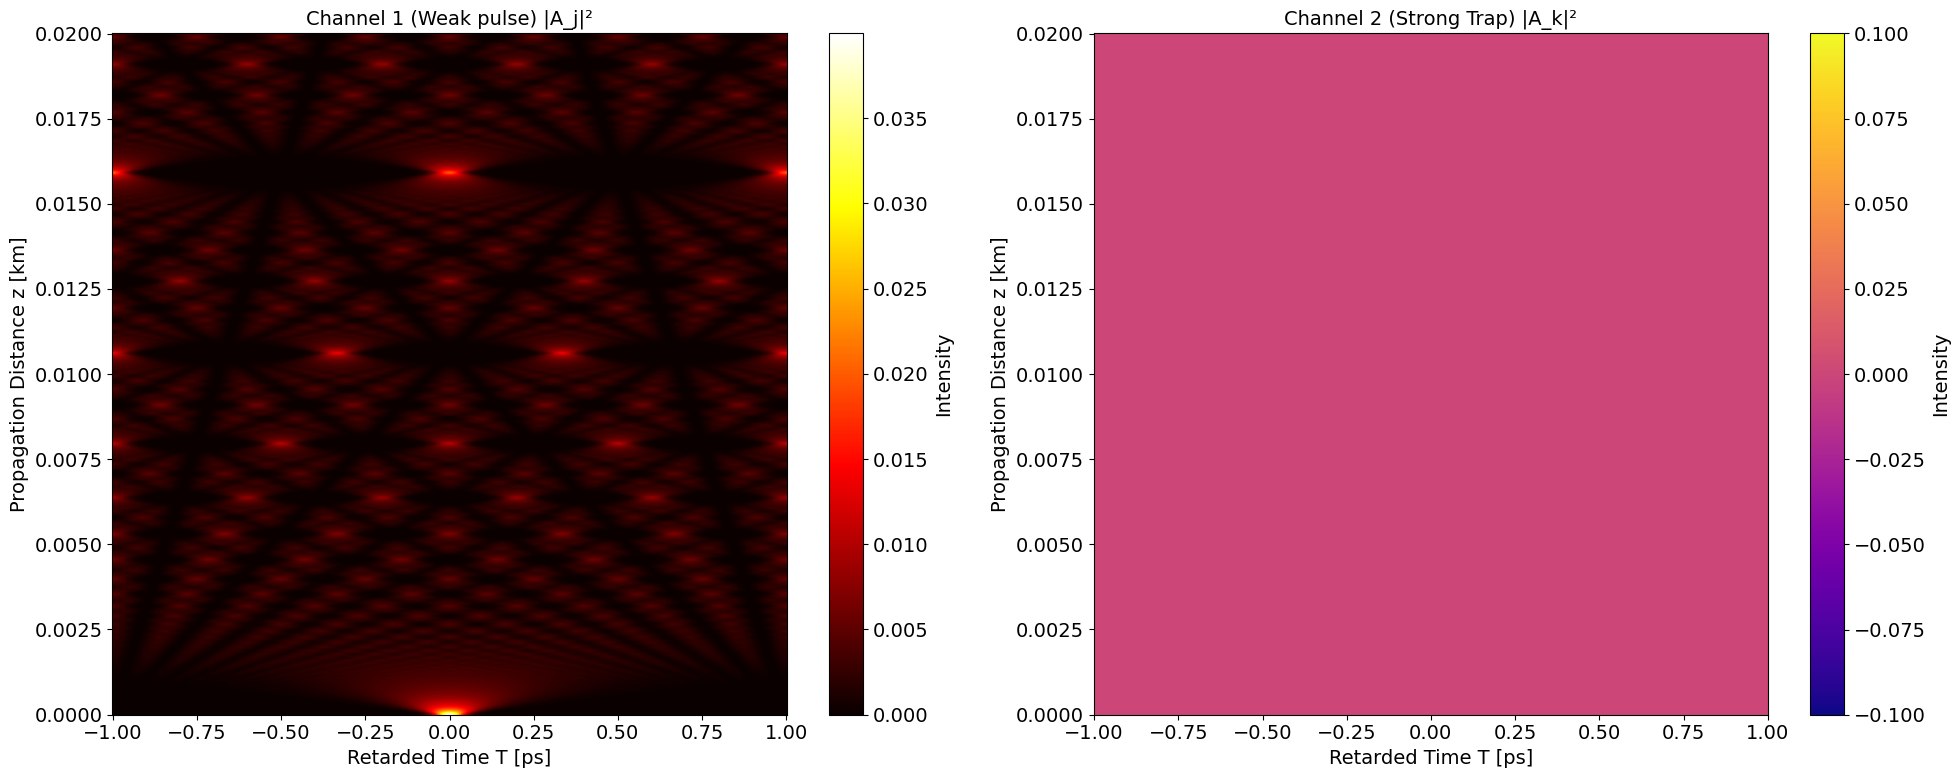

In [36]:
""" Simulation """
Ain_k = torch.zeros_like(Ain_k) # zero the other pulse

# run simulation
A_j_evolution, A_k_evolution  = split_step_fourier_xpm(Ain_j, Ain_k, dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)

""" Plotting """
plot_cowave_evolution(A_j_evolution, A_k_evolution, t, Lz, Nz)